In [72]:
# based on https://github.com/milindmalshe/Fully-Connected-Neural-Network-PyTorch/blob/master/FCN_MNIST_Classification_PyTorch.py
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [73]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
# Hyperparameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001
validation_size = 10000 # number for validation

number_of_seeds = 5 # number of random seeds to generate

In [75]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data/',
										   train=True,
										   transform=transforms.ToTensor(),
										   download=True)

test_dataset = torchvision.datasets.MNIST(root='./data/',
										  train=False,
										  transform=transforms.ToTensor())

# Split dataset into training and validation sets
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, validation_size])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
										   batch_size=batch_size,
										   shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
										  batch_size=batch_size,
										  shuffle=False)

In [76]:
# Fully connected neural network
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden_size, num_classes)  

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		return out

In [77]:
total_step = len(train_loader)
criterion = nn.CrossEntropyLoss() # this is the loss function
seed_numbers = [random.randint(0, 100) for _ in range(number_of_seeds)]

In [78]:
def evaluate_model(model,data_loader):
    total_loss = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data_loader:
            images = images.reshape(-1, 28*28).to(device) # convert to vector
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # takes max of last layer as prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            total_loss+=loss.item()
        
        accuracy = 100 * correct / total
        # print('Accuracy of the network on the {} test images: {:.2f} %'.format(total, accuracy))
        data_errors = total_loss/len(data_loader) # get mean error
        
    return data_errors

In [79]:
def train_model(seed_number):
	# set the seed
	torch.manual_seed(seed_number)
	print("Using seed number: ",seed_number)

	model = NeuralNet(input_size, hidden_size, num_classes).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # this is the algorithm used like gradient descent
		
	# train the model
	all_epochs_test_errors = []
	all_epochs_val_errors = []
	for epoch in range(num_epochs):
		# set model to train mode
		model.train()
		for i, (images, labels) in enumerate(train_loader):
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# if (i+1) % 200 == 0:
			# 	print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
			# 		.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
				
		# get e_te of each epoch
		test_errors = evaluate_model(model,test_loader)
		val_errors = evaluate_model(model,val_loader)
		print('Epoch [{}/{}], Seed [{}] Test Loss: {:.4f}'.format(epoch+1, num_epochs,seed_number, test_errors))

		all_epochs_test_errors.append(test_errors) # aggregate each epoch's error from this seed
		all_epochs_val_errors.append(val_errors) # aggregate each epoch's error from this seed

	return model, all_epochs_test_errors,all_epochs_val_errors


In [80]:
# main
training_tests_errors = []
training_val_errors = []
final_tests_errors    = []
for seed_number in seed_numbers:
    curr_model, curr_test_errors,curr_val_errors = train_model(seed_number)
    training_tests_errors.append(curr_test_errors)
    training_val_errors.append(curr_val_errors)
    final_tests_errors.append(curr_test_errors[-1]) # get last valid test error from each seed

Using seed number:  51
Epoch [1/5], Seed [51] Test Loss: 0.1553
Epoch [2/5], Seed [51] Test Loss: 0.1118
Epoch [3/5], Seed [51] Test Loss: 0.0808
Epoch [4/5], Seed [51] Test Loss: 0.0810
Epoch [5/5], Seed [51] Test Loss: 0.0733
Using seed number:  5
Epoch [1/5], Seed [5] Test Loss: 0.1606
Epoch [2/5], Seed [5] Test Loss: 0.1045
Epoch [3/5], Seed [5] Test Loss: 0.0975
Epoch [4/5], Seed [5] Test Loss: 0.0763
Epoch [5/5], Seed [5] Test Loss: 0.0781
Using seed number:  91
Epoch [1/5], Seed [91] Test Loss: 0.1615
Epoch [2/5], Seed [91] Test Loss: 0.1127
Epoch [3/5], Seed [91] Test Loss: 0.0874
Epoch [4/5], Seed [91] Test Loss: 0.0730
Epoch [5/5], Seed [91] Test Loss: 0.0690
Using seed number:  7
Epoch [1/5], Seed [7] Test Loss: 0.1584
Epoch [2/5], Seed [7] Test Loss: 0.1035
Epoch [3/5], Seed [7] Test Loss: 0.0931
Epoch [4/5], Seed [7] Test Loss: 0.0901
Epoch [5/5], Seed [7] Test Loss: 0.0676
Using seed number:  18
Epoch [1/5], Seed [18] Test Loss: 0.1630
Epoch [2/5], Seed [18] Test Loss: 0.

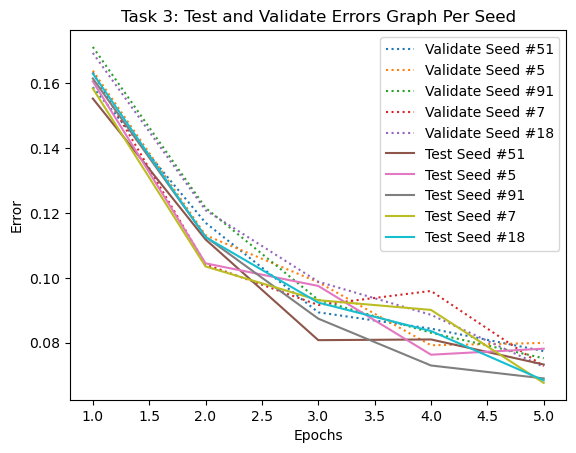

In [81]:
# Graphs for each seed
seed_id = 0
for i,curr_training_val_error in enumerate(training_val_errors):
    x_axis = np.arange(1, len(curr_training_val_error) + 1) # so x axis is from 1 to 5
    plt.plot(x_axis,curr_training_val_error, label=f'Validate Seed #{seed_numbers[seed_id]}', linestyle=":")
    seed_id+=1

seed_id = 0
for i,curr_training_tests_error in enumerate(training_tests_errors):
    x_axis = np.arange(1, len(curr_training_tests_error) + 1) # so x axis is from 1 to 5
    plt.plot(x_axis,curr_training_tests_error, label=f'Test Seed #{seed_numbers[seed_id]}')
    seed_id+=1

plt.ylabel("Error")
plt.xlabel("Epochs")
plt.title("Task 3: Test and Validate Errors Graph Per Seed")
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

In [86]:
print("Corresponding test error to minimum validation error:")
for i,seed in enumerate(seed_numbers):
    min_error_val = min(training_val_errors[i])
    index_of_min = training_val_errors[i].index(min_error_val)
    min_correspond_test = training_tests_errors[i][index_of_min]
    print('Seed {}: ({:.4f},{:.4f})'.format(seed,min_correspond_test,min_error_val))

print("    e_te* ^ e_va* ^")

Corresponding test error to minimum validation error:
Seed 51: (0.0733,0.0774)
Seed 5: (0.0763,0.0792)
Seed 91: (0.0690,0.0752)
Seed 7: (0.0676,0.0727)
Seed 18: (0.0684,0.0725)
    e_te* ^ e_va* ^
